In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bước 1

In [2]:

# Load the image
def segment_rabbits(image_path):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to RGB (OpenCV loads as BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # Define range for beige/cream color of rabbits
    # You may need to adjust these values based on the specific image
    lower_beige = np.array([15, 30, 150])
    upper_beige = np.array([100, 200, 240])
    
    # Create a mask for beige/cream colors
    mask = cv2.inRange(img_hsv, lower_beige, upper_beige)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply the mask to get only the rabbits
    rabbits_only = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_rgb)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.title('HSV Image')
    plt.imshow(img_hsv)
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.title('Segmented Rabbits')
    plt.imshow(rabbits_only)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return mask, rabbits_only

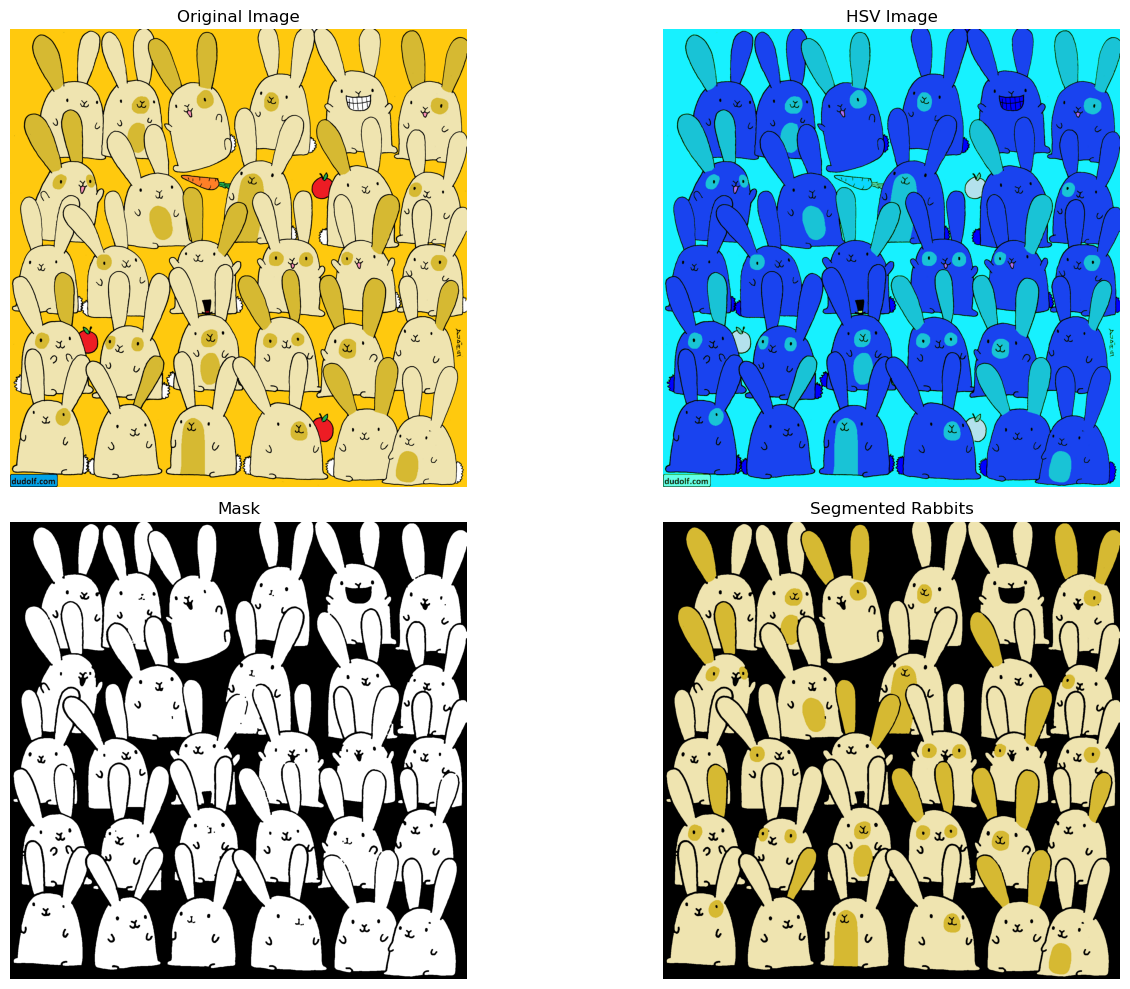

In [3]:
mask, rabbits_only = segment_rabbits('rabbit2.jpg')

In [4]:
rabbits_only.shape

(2048, 2047, 3)

# Bước 2

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_rabbit_contours(segmented_image):
    # Convert to grayscale if the image has color channels
    if len(segmented_image.shape) > 2:
        gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = segmented_image.copy()
    
    # 1. Convert to binary image
    # Use threshold to convert any non-zero pixel to 255 (white)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    # 2. Smooth the image to reduce noise
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)
    
    # 3. Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # 4. Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create images for visualization
    contour_img = np.zeros_like(binary)
    
    # Draw all contours
    cv2.drawContours(contour_img, contours, -1, 255, 2)

    return contour_img


result_img = detect_rabbit_contours(rabbits_only)


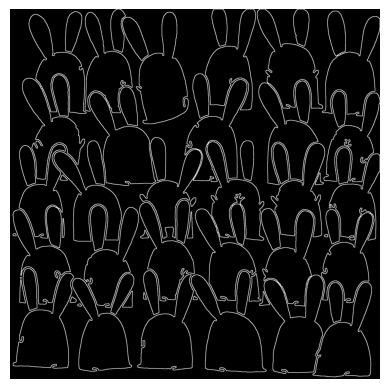

In [6]:
plt.axis('off')
plt.imshow(result_img, cmap='gray')


# Bước 3

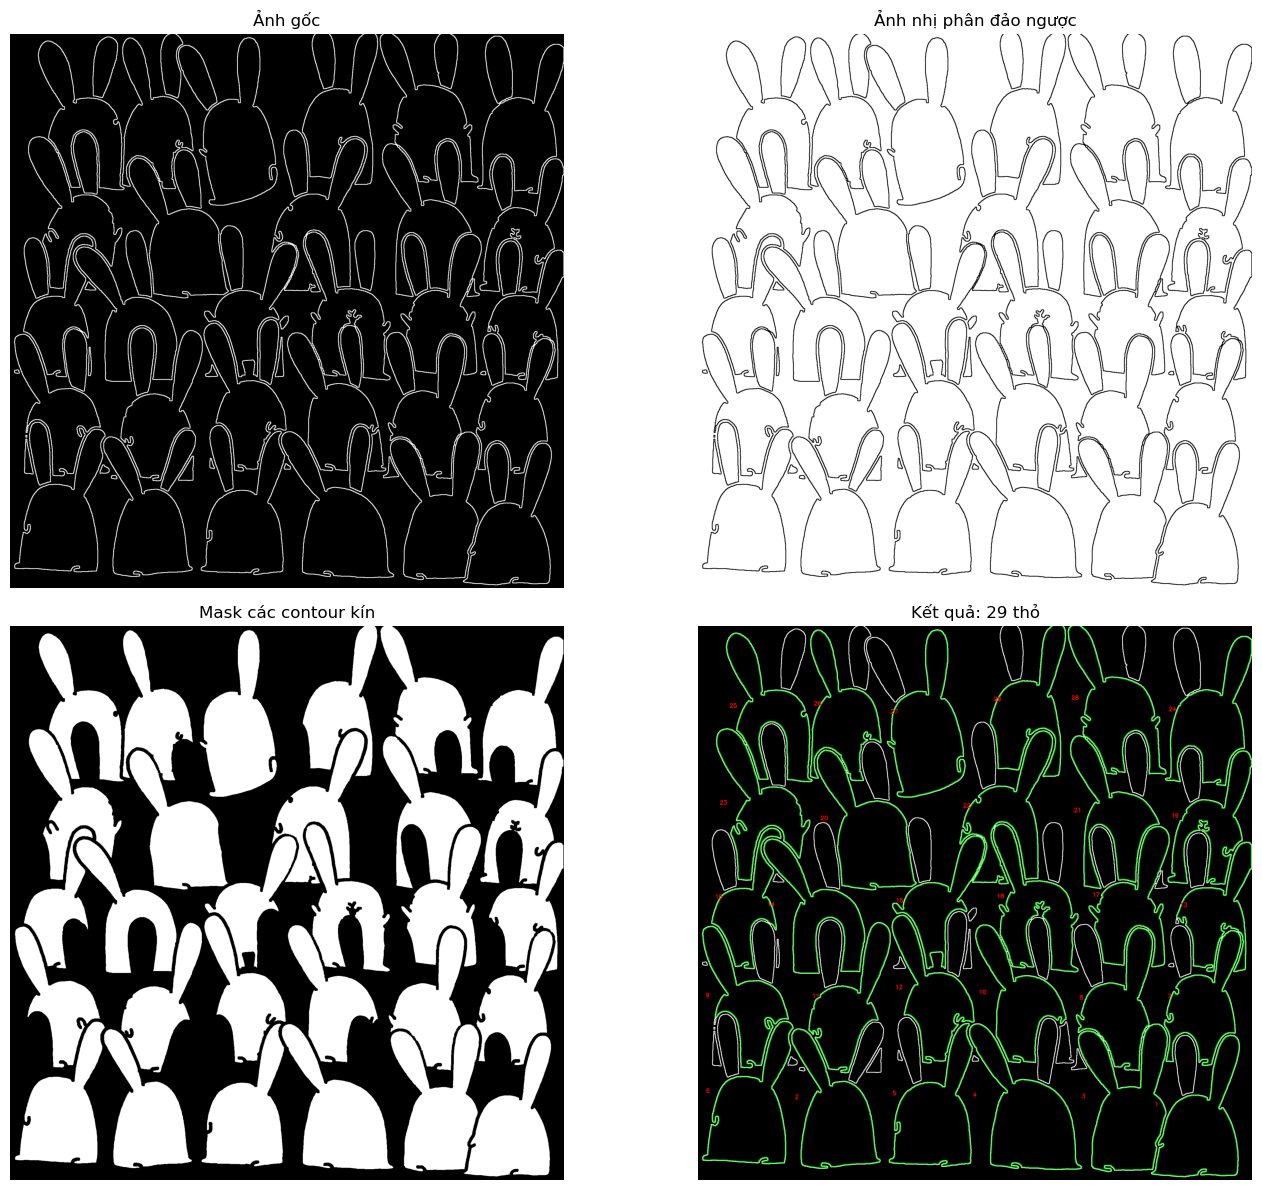

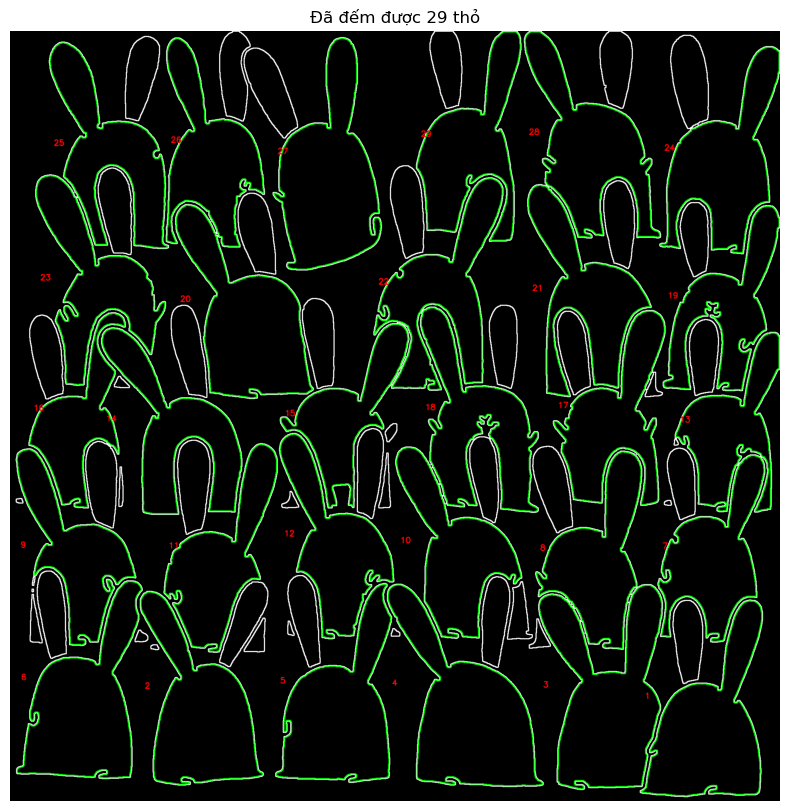

Số thỏ được phát hiện: 29


In [7]:
def count_and_visualize_rabbits(image):
    # Đọc ảnh
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Tạo bản sao màu để vẽ kết quả
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Áp dụng ngưỡng để tách biệt đường viền
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    # Nghịch đảo để đường viền trắng trở thành đen
    binary_inv = cv2.bitwise_not(binary)
    
    # ĐIỀU CHỈNH 1: Tìm các đường viền kín (closed contours)
    # Sử dụng RETR_CCOMP để tìm các đường viền dạng phân cấp
    contours, hierarchy = cv2.findContours(binary_inv, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # Tạo một mask để lưu các đường viền kín
    mask = np.zeros_like(binary)
    
    # ĐIỀU CHỈNH 2: Chỉ giữ lại các contour kín (closed)
    rabbit_count = 0
    for i, contour in enumerate(contours):
        # Kiểm tra nếu contour là đường viền ngoài cùng (external contour)
        if hierarchy[0][i][3] == -1:  # Parent là -1 nghĩa là đây là contour ngoài cùng
            # Kiểm tra xem contour có đóng kín không
            is_closed = True
            
            # Tính diện tích và chu vi của contour
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            
            # Tính tỷ lệ khung hình
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = h/w if w > 0 else 0
            
            # ĐIỀU CHỈNH 3: Lọc contour dựa trên kích thước và hình dạng
            # Chỉ giữ lại những contour có kích thước phù hợp với thỏ
            if 20000 < area < 120000 and 0.8 < aspect_ratio < 3.0:
                # ĐIỀU CHỈNH 4: Kiểm tra tính kín của contour qua convexity defects
                hull = cv2.convexHull(contour, returnPoints=False)
                if len(hull) > 3:  # Cần ít nhất 4 điểm để tính convexity defects
                    try:
                        defects = cv2.convexityDefects(contour, hull)
                        if defects is not None:
                            # Đếm số lượng defects đáng kể
                            significant_defects = 0
                            for defect in defects:
                                _, _, _, depth = defect[0]
                                if depth > 500:  # Ngưỡng độ sâu của defect
                                    significant_defects += 1
                            
                            # Nếu có quá nhiều defects, đây có thể là khoảng hở giữa các thỏ
                            if significant_defects <= 9:  # Điều chỉnh ngưỡng này
                                cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)
                                cv2.putText(output_image, str(rabbit_count+1), (x+10, y+h//2), 
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                                rabbit_count += 1
                                # Vẽ contour vào mask
                                cv2.drawContours(mask, [contour], -1, 255, -1)
                    except:
                        # Xử lý trường hợp không tính được convexity defects
                        pass
    
    # ĐIỀU CHỈNH 5: Thêm bước hiển thị trung gian
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Ảnh gốc")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(binary_inv, cmap='gray')
    axes[0, 1].set_title("Ảnh nhị phân đảo ngược")
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(mask, cmap='gray')
    axes[1, 0].set_title("Mask các contour kín")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(f"Kết quả: {rabbit_count} thỏ")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig("process_steps_closed_contours.jpg")
    plt.show()
    
    # Hiển thị kết quả cuối cùng
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Đã đếm được {rabbit_count} thỏ")
    plt.axis('off')
    plt.savefig("counted_rabbits_closed.jpg")
    plt.show()
    
    return rabbit_count, output_image

# Sử dụng
result, output_img = count_and_visualize_rabbits(result_img)
print(f"Số thỏ được phát hiện: {result}")